In [41]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [43]:
data_path = r"C:\Users\kumar\Desktop\dataset"
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [45]:
print("Categories:", categories)
print("Label Mapping:", label_dict)

Categories: ['with mask', 'without mask']
Label Mapping: {'with mask': 0, 'without mask': 1}


In [47]:
img_size = 100
data = []
target = []

In [49]:
# 2️⃣ Read & Preprocess Images
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping unreadable image: {img_path}")
            continue  # Skip corrupted images

        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            resized = cv2.resize(gray, (img_size, img_size))  # Resize to 100x100
            data.append(resized)
            target.append(label_dict[category])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [51]:
# 3️⃣ Convert Data to Numpy Arrays
data = np.array(data) / 255.0  # Normalize images
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))  # Reshape for CNN
target = np.array(target)

In [53]:
# 4️⃣ Convert Labels to One-Hot Encoding
target = to_categorical(target)

In [55]:
# Save preprocessed data
np.save('data.npy', data)
np.save('target.npy', target)


In [57]:
# 5️⃣ Load Data
data = np.load('data.npy')
target = np.load('target.npy')

In [59]:
# 6️⃣ Define CNN Model
model = Sequential()
model.add(Conv2D(200, (3,3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))  # Output layer for multiple categories

C:\Users\kumar\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 200)    │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 98, 98, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 47, 47, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │     2,645,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,252 (10.79 MB)

 Trainable params: 2,827,252 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# 7️⃣ Train-Test Split (Check for small dataset)
if len(data) > 1:
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.1)
else:
    print("Not enough samples for train-test split. Add more images.")
    exit()

In [67]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.keras', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')


In [69]:
history = model.fit(train_data, train_target, epochs=20, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.5573 - loss: 0.7069 - val_accuracy: 0.7284 - val_loss: 0.6406
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.7531 - loss: 0.5480 - val_accuracy: 0.7198 - val_loss: 0.5522
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.7850 - loss: 0.4700 - val_accuracy: 0.7414 - val_loss: 0.5024
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.8239 - loss: 0.4009 - val_accuracy: 0.7931 - val_loss: 0.4281
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.8575 - loss: 0.3276 - val_accuracy: 0.8276 - val_loss: 0.3921
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy: 0.8672 - loss: 0.2978 - val_accuracy: 0.8190 - val_loss: 0.4054
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.9396 - loss: 0.1734 - val_accuracy: 0.8276 - val_loss: 0.4077
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.9348 - loss: 0.1752 - val_accuracy: 

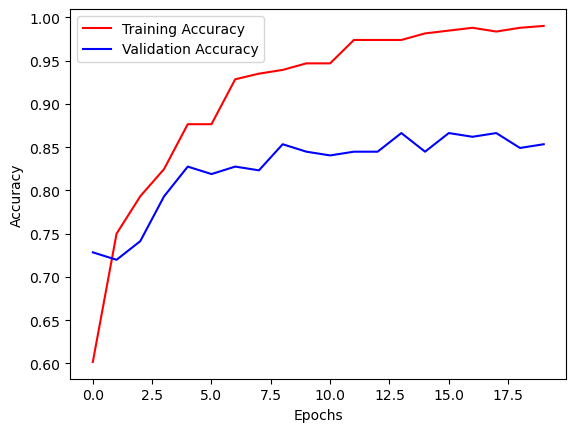

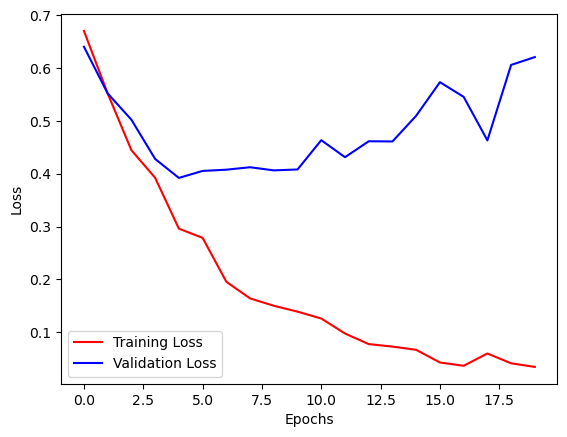

In [71]:
# 9️⃣ Plot Accuracy & Loss
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
# 🔟 Evaluate Model
print("Test Evaluation:", model.evaluate(test_data, test_target))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9243 - loss: 0.2071
Test Evaluation: [0.23175325989723206, 0.9147287011146545]


In [79]:
# 1️⃣1️⃣ Load Trained Model
model = load_model('model-005.keras')



In [81]:
# 1️⃣2️⃣ Live Face Mask Detection with OpenCV
face_clsfr = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [86]:
labels_dict = {0: 'MASK', 1: 'NO MASK'}
color_dict = {0: (0,255,0), 1: (0,0,255)}

source = cv2.VideoCapture(0)  # Open webcam

while True:
    ret, frame = source.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)

    for x, y, w, h in faces:
        face_img = gray[y:y+h, x:x+w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result)

        cv2.rectangle(frame, (x, y), (x + w, y + h), color_dict[label], 2)
        cv2.rectangle(frame, (x, y - 40), (x + w, y), color_dict[label], -1)
        cv2.putText(frame, labels_dict[label], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow('Live Mask Detection', frame)
    key = cv2.waitKey(1)

    if key == 27:  # Press 'Esc' to exit
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [89]:
cv2.destroyAllWindows()
source.release()